In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# 0. Réglages Colab

In [6]:
!pip install pyod
!pip install suod 

In [7]:
%cd /content/drive/My\ Drive/TAA
%load_ext autoreload
%autoreload 2

/content/drive/My Drive/TAA


In [ ]:
from scipy import stats
import scipy.io
from sklearn.svm import OneClassSVM
import time
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons, make_blobs
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from pyod.models.knn import KNN
from pyod.models.abod import ABOD
from pyod.models.hbos import HBOS
import tensorflow as tf
import keras
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from sklearn.preprocessing import  StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score,confusion_matrix

In [0]:
from utils.evaluate import plot_var_in_out, evaluation_detection, deep_predict, evaluate
from utils.preprocessing import upload_data, split_data, prepro_data, simul_gaussian_data, simul_uniform_data
from utils.train_test import CustomAutoencoder, AlgoTrainPredict

Plan du notebook
0.   Réglages Colab
1.   **Statistique descriptive** \\
  1.1 Base satimage \\
  1.2 Base speech \\
  1.3 Bases simulées \\
2.   **Détection d'anomalies** \\
  2.1 Cas des bases simulation \\
  2.2 Cas de satimage \\
  2.3 Cas de speech \\
3.   **Détection de nouveautés** \\
  3.1 Cas des bases simulation \\
  3.2 Cas de satimage \\
  3.3 Cas de speech \\




# 1. Statistique descriptive

In [0]:
path = "data/"

### 1.1 Base satimage

Base satimage
Proportion d'anomalies :  0.0122350508357746


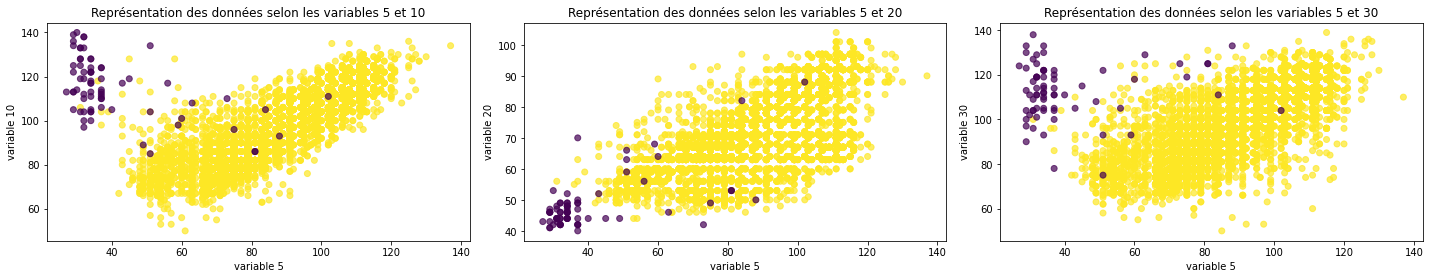

In [0]:
print("Base satimage")
X, y = upload_data(path + 'satimage-2.mat')
print("Proportion d'anomalies : ",np.sum(y==-1)/len(y))
plot_var_in_out(X,y,5,10,20,30)

### 1.2 Base speech

Base speech
Proportion d'anomalies :  0.016549104720564298


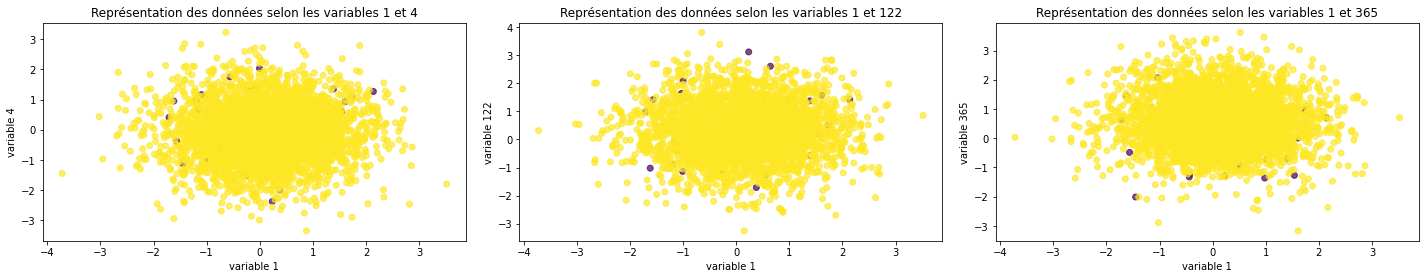

In [0]:
print("Base speech")
X_speech, y_speech = upload_data(path + 'speech.mat')
print("Proportion d'anomalies : ",np.sum(y_speech==-1)/len(y_speech))
plot_var_in_out(X_speech,y_speech,1,4,122,365)

### 1.3 Bases simulées

Anomalies gaussiennes et données "normales"

Données simulées avec anomalies gaussiennes
Proportion d'anomalies :  0.014778325123152709


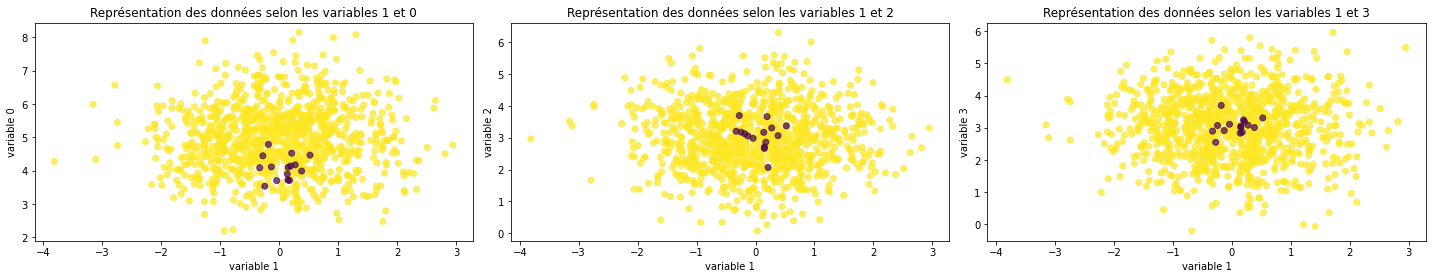

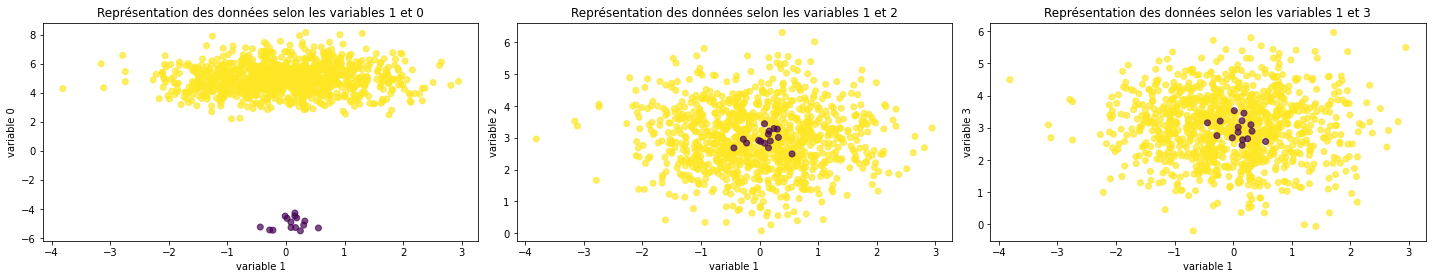

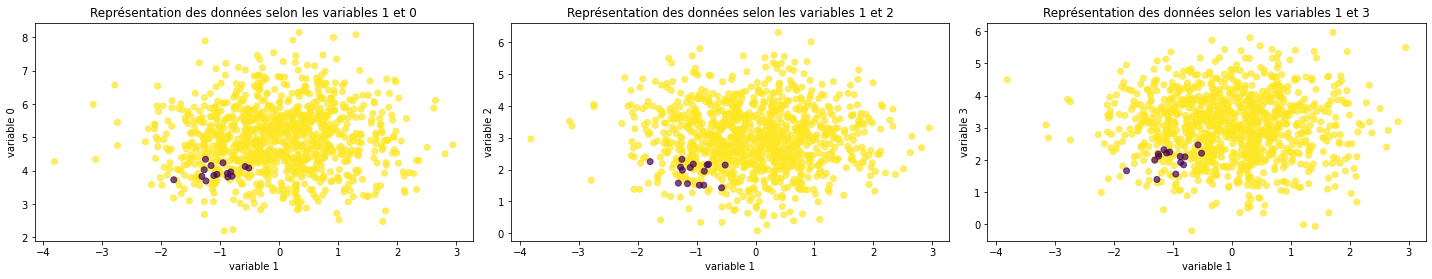

In [0]:
nb_inlier,nb_outlier = 1000, 15
nb_var = 1000
X_normal, mean_normal, gaussian_anomaly_list = simul_gaussian_data(nb_var,nb_outlier, nb_inlier)

print("Données simulées avec anomalies gaussiennes")
print("Proportion d'anomalies : ",nb_outlier/(nb_inlier+nb_outlier))

for index in range(len(gaussian_anomaly_list)):
    X = np.concatenate([X_normal, gaussian_anomaly_list[index]])
    y = np.concatenate([np.ones(nb_var),-np.ones(nb_outlier)])
    plot_var_in_out(X,y,1,0,2,3)
    data = {'X': X,'y': y}
    scipy.io.savemat(path + 'simulation_gaussienne_'+str(index)+'.mat', data)

Anomalies uniformes

Simulation d'anomalies uniformes
Proportion d'anomalies :  0.014778325123152709


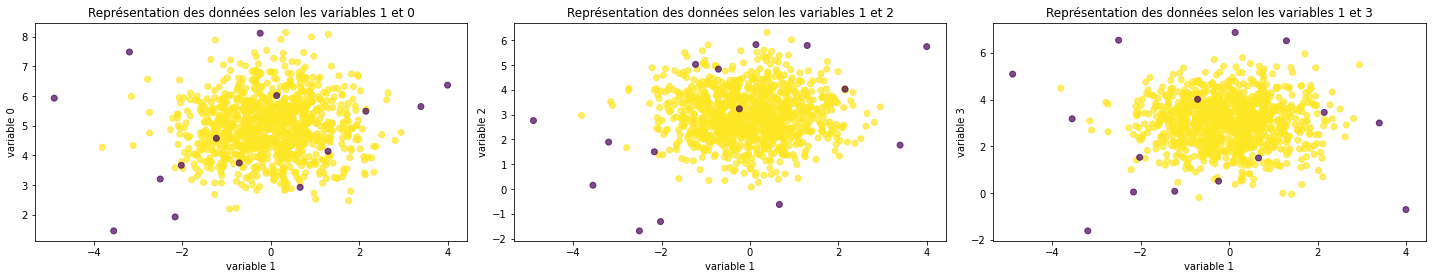

In [0]:
print("Simulation d'anomalies uniformes")
print("Proportion d'anomalies : ",nb_outlier/(nb_inlier+nb_outlier))

uniform_anomaly = simul_uniform_data(nb_var,nb_outlier,mean_normal)
X = np.concatenate([X_normal,uniform_anomaly])
y = np.concatenate([np.ones(nb_var),-np.ones(nb_outlier)])
plot_var_in_out(X,y,1,0,2,3)
data = {'X': X,'y': y}
scipy.io.savemat(path + 'simulation_uniforme.mat', data)

# 2. Détection d'anomalies

### 2.0 Configuration

In [0]:
config={"nb_epoch" : 200,
       "batch_size" : 50,
       "outlier_prop" : 0.03}
# Definition de la proportion d'anomalies 
outlier_prop = config["outlier_prop"]

### 2.1 Cas de Simulation

In [0]:
# Definition de l'autoencoder
input_dim = nb_var
autoencoder=CustomAutoencoder(input_dim)
nb_epoch = config["nb_epoch"]
batch_size = config["batch_size"]
autoencoder.compile(optimizer='adam', loss='mse' )

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
dense_25 (Dense)             (None, 10)                10010     
_________________________________________________________________
dense_26 (Dense)             (None, 5)                 55        
_________________________________________________________________
dense_27 (Dense)             (None, 2)                 12        
_________________________________________________________________
dense_28 (Dense)             (None, 5)                 15        
_________________________________________________________________
dense_29 (Dense)             (None, 10)                60        
_________________________________________________________________
dense_30 (Dense)             (None, 1000)              1100

In [ ]:
anomaly_algorithms_simul = [
    ("Robust covariance", EllipticEnvelope(contamination=outlier_prop)),
    ("One-Class SVM", OneClassSVM(nu=outlier_prop, kernel="rbf", gamma=0.0001)),
    ("Isolation Forest", IsolationForest(n_estimators=300, max_samples = 600, contamination=outlier_prop, max_features=30, random_state=42)),
    ("KNN", KNN(contamination = outlier_prop, n_neighbors=30)),
    ("Deep MLP", autoencoder),
    ("Local Outlier Factor", LocalOutlierFactor(n_neighbors=15, contamination=outlier_prop))
    ]
algo_particuliers = ["KNN","Local Outlier Factor","Deep MLP","Robust covariance"]

##### Simulations d'anomalies gaussiennes

%%%%%%%%%%%%%%%%%% index =  0


/usr/local/lib/python3.6/dist-packages/sklearn/covariance/_robust_covariance.py:644: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "


---------Robust covariance-----------
   accuracy  recall  True negative rate  False discovery rate
0       1.0     1.0                 0.0                   0.0


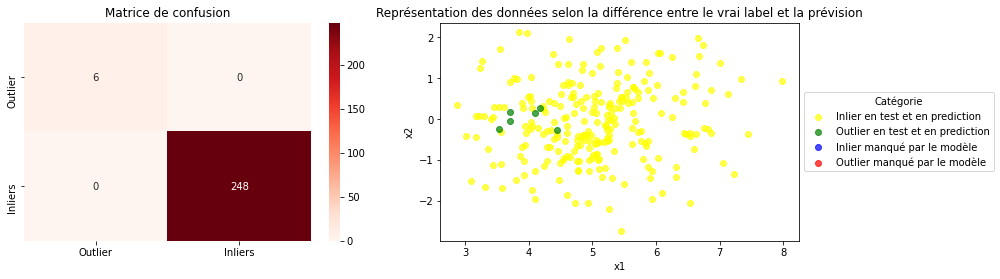

---------One-Class SVM-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.858268  0.439516            0.120968              0.026786


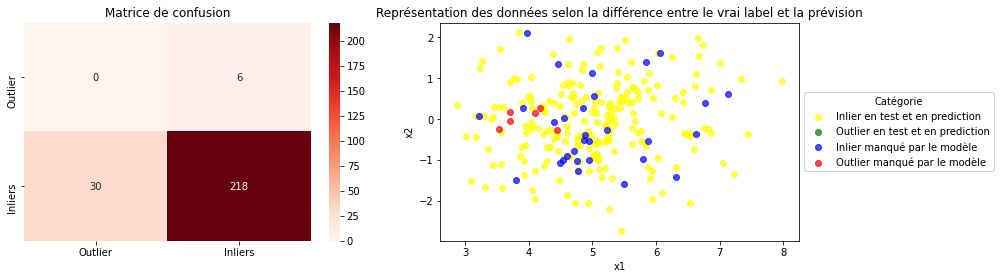

---------Isolation Forest-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.940945  0.481855             0.03629               0.02449


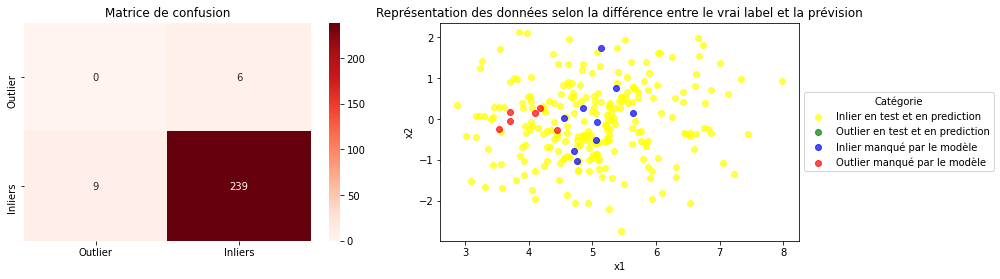

---------KNN-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.940945  0.481855             0.03629               0.02449


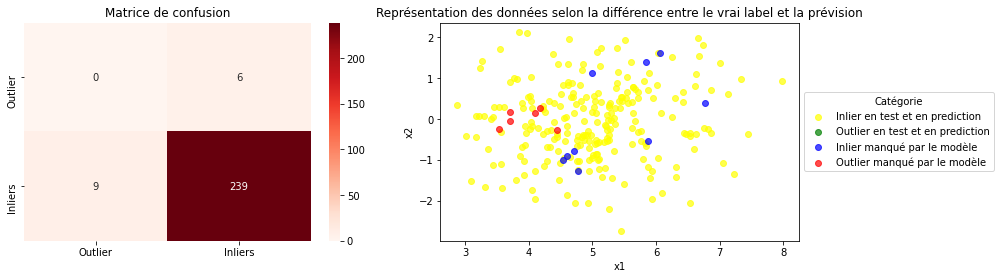

---------Deep MLP-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.972441  0.497984            0.004032              0.023715


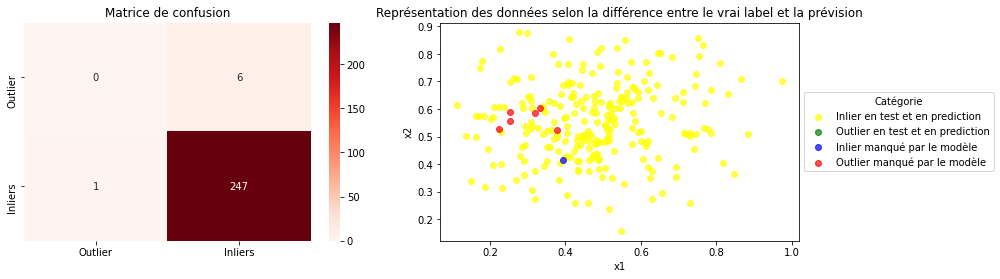

---------Local Outlier Factor-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.944882  0.483871            0.032258               0.02439


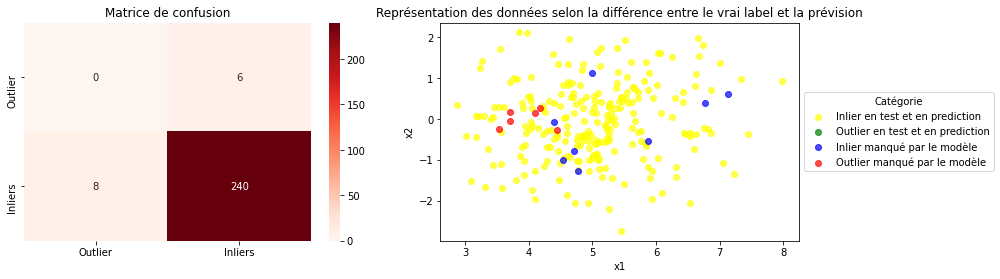

%%%%%%%%%%%%%%%%%% index =  1


/usr/local/lib/python3.6/dist-packages/sklearn/covariance/_robust_covariance.py:644: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "


---------Robust covariance-----------
   accuracy  recall  True negative rate  False discovery rate
0       1.0     1.0                 0.0                   0.0


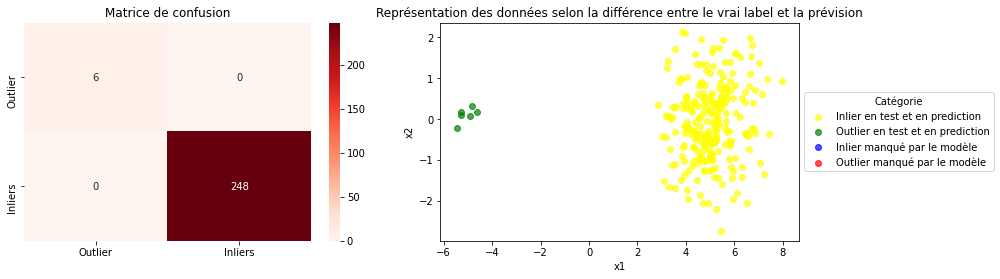

---------One-Class SVM-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.858268  0.439516            0.120968              0.026786


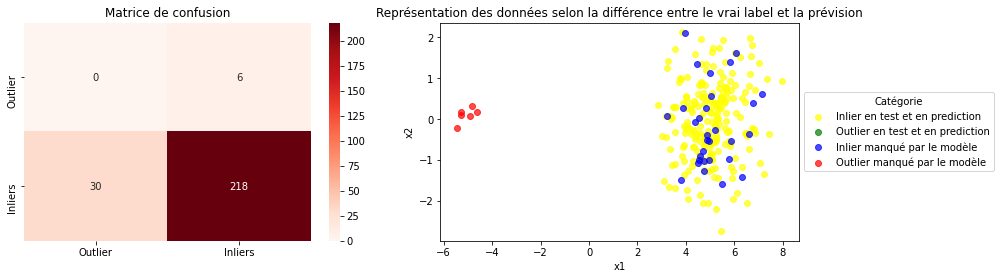

---------Isolation Forest-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.937008  0.479839            0.040323               0.02459


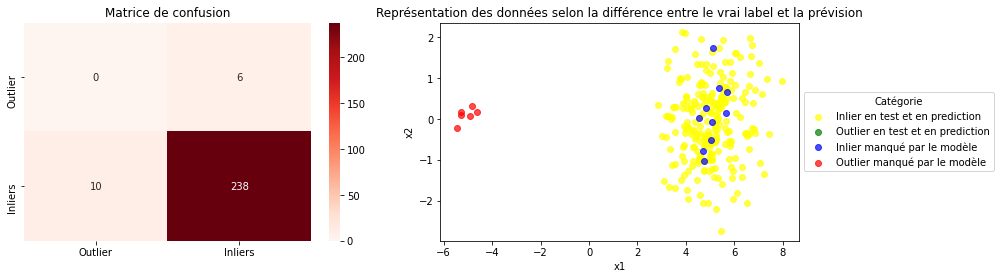

---------KNN-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.940945  0.481855             0.03629               0.02449


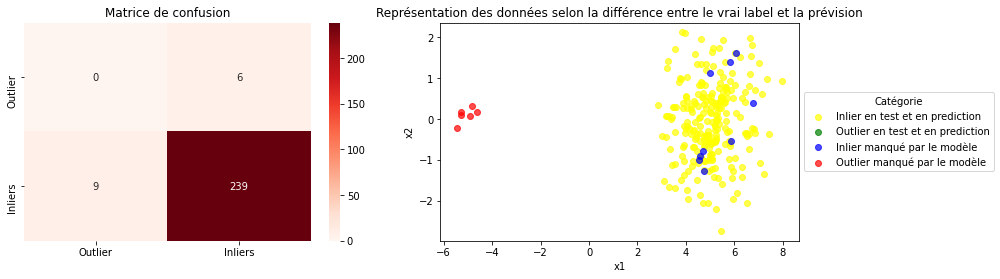

---------Deep MLP-----------
   accuracy  recall  True negative rate  False discovery rate
0  0.976378     0.5                 0.0              0.023622


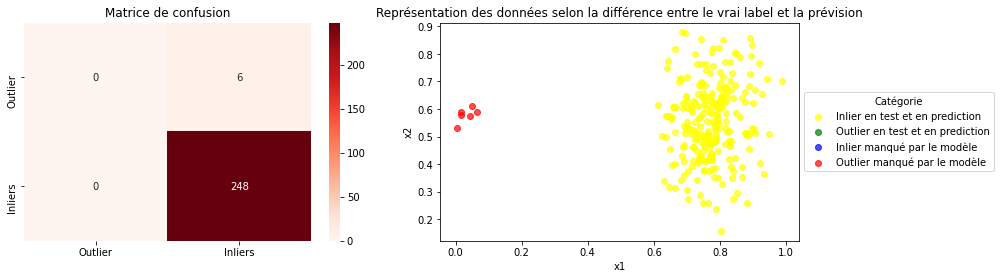

---------Local Outlier Factor-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.944882  0.483871            0.032258               0.02439


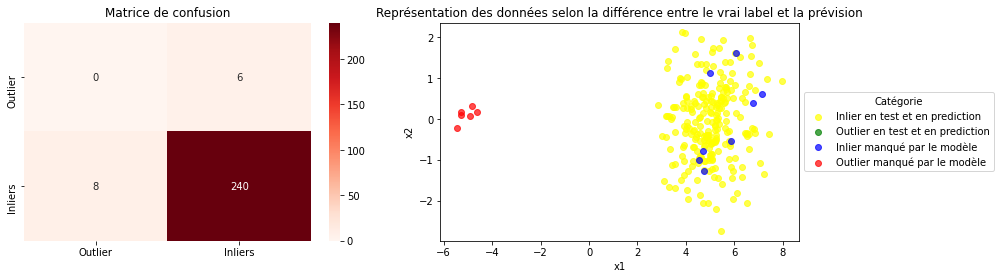

%%%%%%%%%%%%%%%%%% index =  2


/usr/local/lib/python3.6/dist-packages/sklearn/covariance/_robust_covariance.py:644: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "


---------Robust covariance-----------
   accuracy  recall  True negative rate  False discovery rate
0       1.0     1.0                 0.0                   0.0


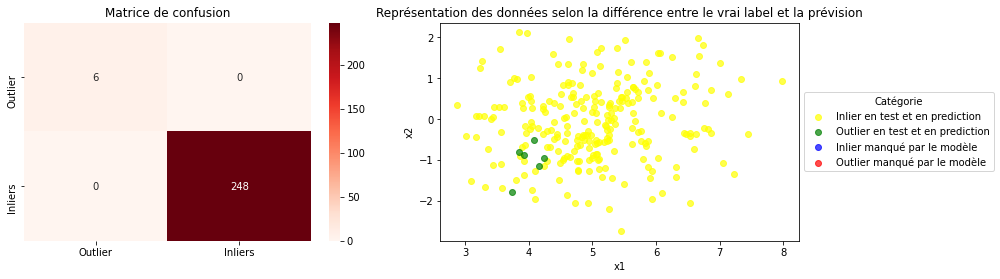

---------One-Class SVM-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.858268  0.439516            0.120968              0.026786


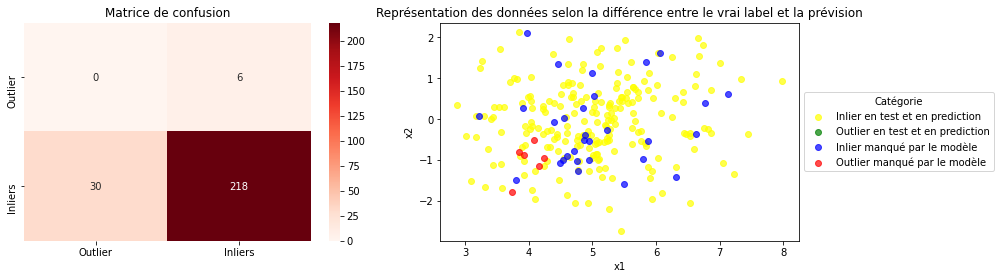

---------Isolation Forest-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.944882  0.483871            0.032258               0.02439


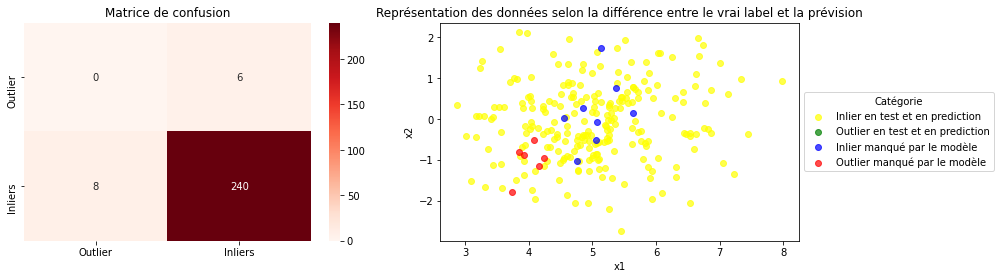

---------KNN-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.940945  0.481855             0.03629               0.02449


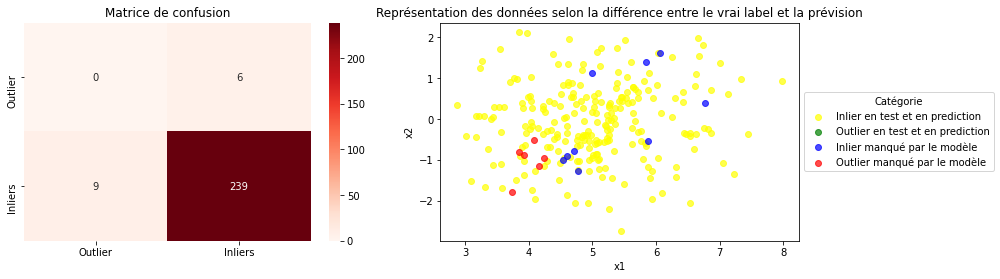

---------Deep MLP-----------
   accuracy  recall  True negative rate  False discovery rate
0  0.976378     0.5                 0.0              0.023622


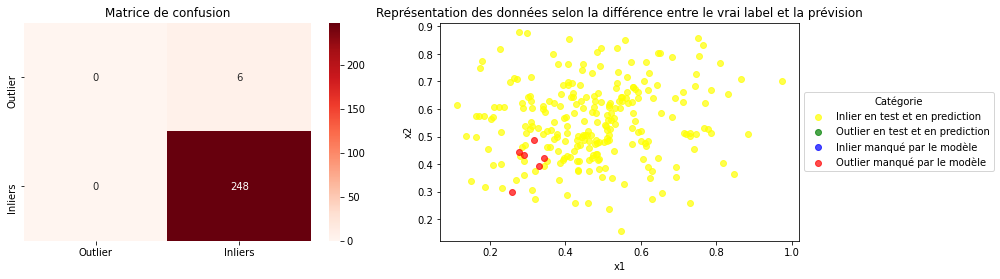

---------Local Outlier Factor-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.944882  0.483871            0.032258               0.02439


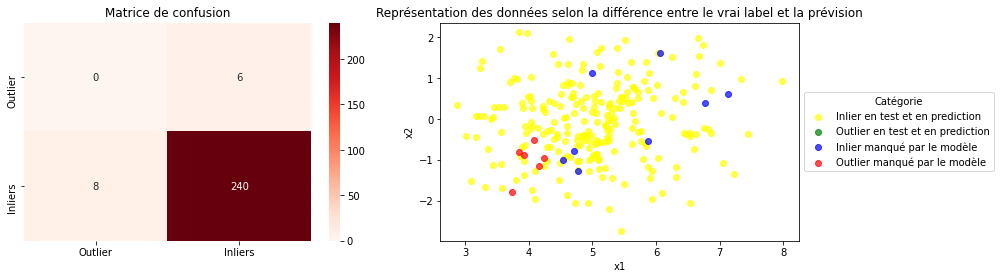

In [0]:
for index in range(len(gaussian_anomaly_list)):
    print("%%%%%%%%%%%%%%%%%% index = ",index)
    X_train, X_test, y_train, y_test, X_train_scaled, X_test_scaled = prepro_data(path + 'simulation_gaussienne_'+str(index)+'.mat', 'anomalies')
    for name, algorithm in anomaly_algorithms_simul:
        AlgoTrainPredict(name, algorithm, algo_particuliers, X_train, X_test, y_test, config, scale="MinMax",var1=0,var2=1)

Simulations d'anomalies uniformes

/usr/local/lib/python3.6/dist-packages/sklearn/covariance/_robust_covariance.py:644: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "


---------Robust covariance-----------
   accuracy  recall  True negative rate  False discovery rate
0  0.976378     0.5                 0.0              0.023622


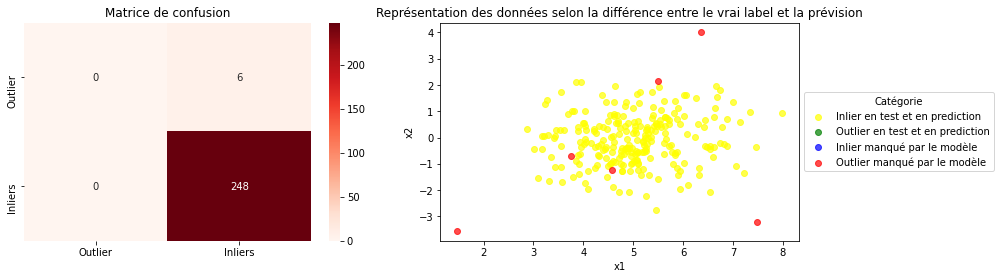

---------One-Class SVM-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.885827  0.941532            0.116935                   0.0


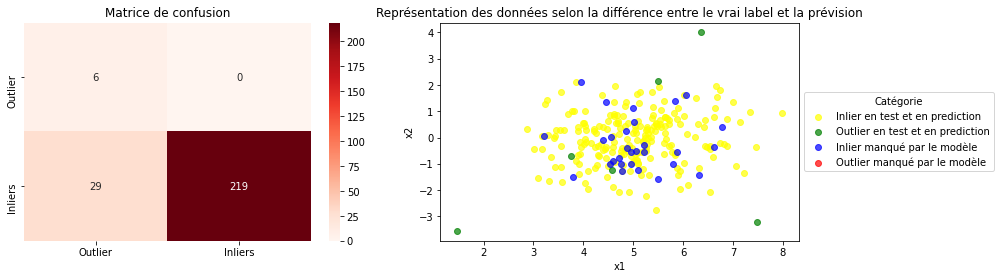

---------Isolation Forest-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.980315  0.989919            0.020161                   0.0


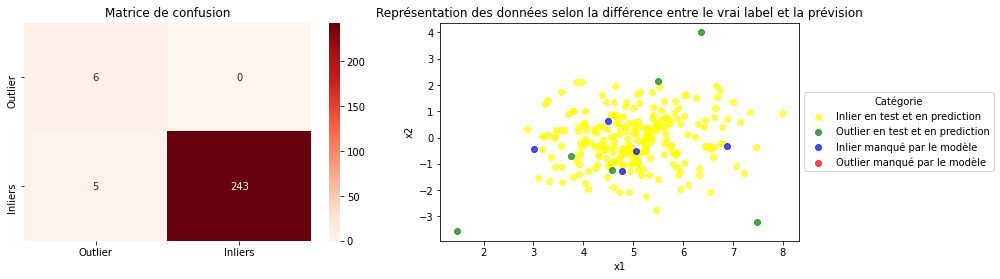

---------KNN-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.988189  0.993952            0.012097                   0.0


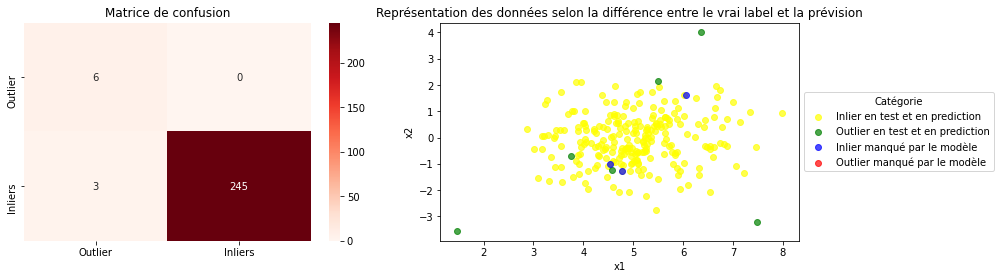

---------Deep MLP-----------
   accuracy  recall  True negative rate  False discovery rate
0       1.0     1.0                 0.0                   0.0


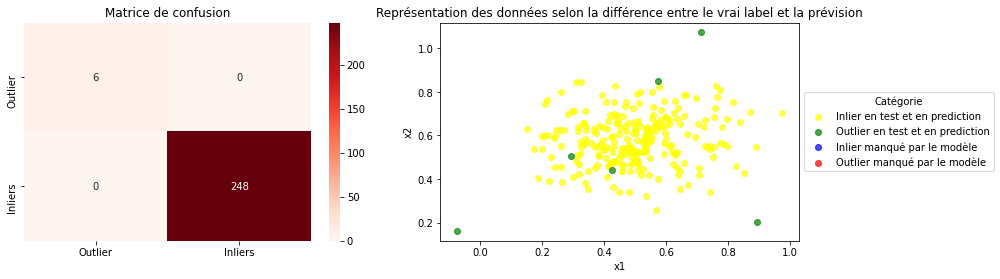

---------Local Outlier Factor-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.992126  0.995968            0.008065                   0.0


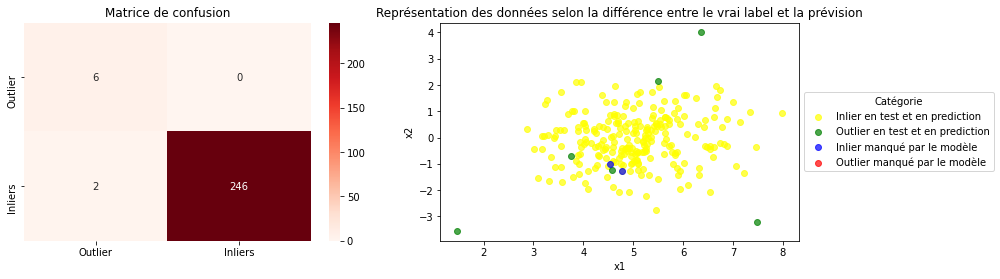

In [0]:
X_train, X_test, y_train, y_test, X_train_scaled, X_test_scaled = prepro_data(path + 'simulation_uniforme.mat', 'anomalies')
for name, algorithm in anomaly_algorithms_simul:
    AlgoTrainPredict(name, algorithm, algo_particuliers, X_train, X_test, y_test, config, scale="MinMax",var1=0,var2=1)

### 2.2 Cas de satimage

In [0]:
X_train, X_test, y_train, y_test, X_train_scaled, X_test_scaled = prepro_data(path + 'satimage-2.mat', 'anomalies')

In [0]:
input_dim = X_train.shape[1]
autoencoder=CustomAutoencoder(input_dim)
nb_epoch = config["nb_epoch"]
batch_size = config["batch_size"]
autoencoder.compile(optimizer='adam', loss='mse' )

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 36)                0         
_________________________________________________________________
dense_31 (Dense)             (None, 10)                370       
_________________________________________________________________
dense_32 (Dense)             (None, 5)                 55        
_________________________________________________________________
dense_33 (Dense)             (None, 2)                 12        
_________________________________________________________________
dense_34 (Dense)             (None, 5)                 15        
_________________________________________________________________
dense_35 (Dense)             (None, 10)                60        
_________________________________________________________________
dense_36 (Dense)             (None, 36)                396 

In [0]:
anomaly_algorithms_satimage = [
    ('ABOD', ABOD(contamination=outlier_prop, n_neighbors=30)),
    ('HBOS', HBOS(contamination=outlier_prop)),
    ("One-Class SVM", OneClassSVM(nu=outlier_prop, kernel="rbf", gamma=0.0001)),
    ("Isolation Forest", IsolationForest(n_estimators=300, max_samples = 600, contamination=outlier_prop, max_features=30, random_state=42)),
    ("KNN", KNN(contamination = outlier_prop, n_neighbors=30)),
    ("Deep MLP", autoencoder),
    ("Local Outlier Factor", LocalOutlierFactor(n_neighbors=15, contamination=outlier_prop))
    ]
algo_particuliers = ["ABOD","HBOS","KNN","Local Outlier Factor","Deep MLP"]

---------ABOD-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.968987  0.780868            0.026499              0.004989


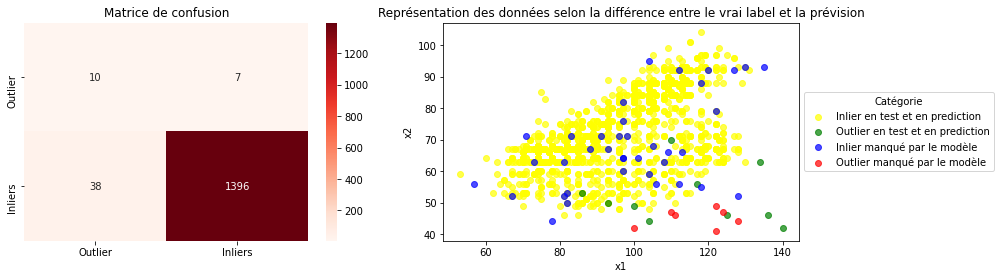

---------HBOS-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.973811  0.841435            0.023013              0.003556


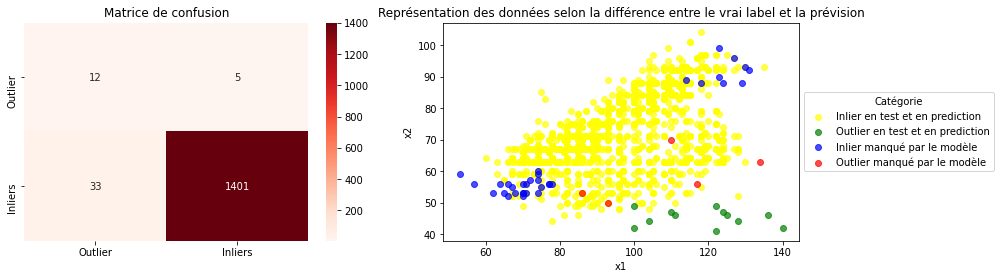

---------One-Class SVM-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.971744  0.869452            0.025802              0.002855


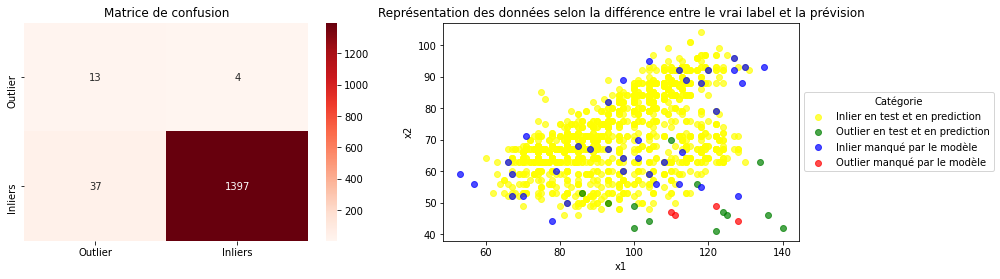

---------Isolation Forest-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.978635  0.989191            0.021618                   0.0


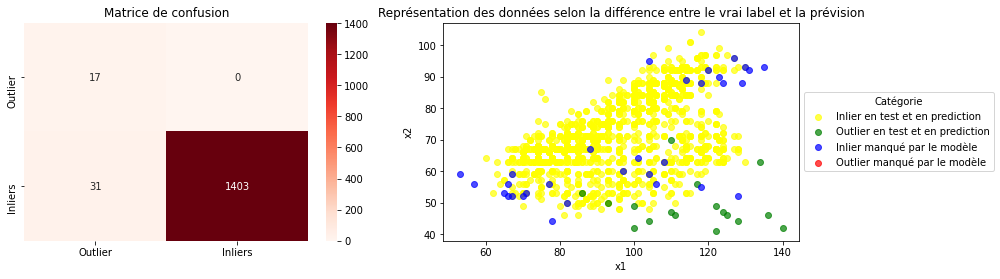

---------KNN-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.977257  0.988494            0.023013                   0.0


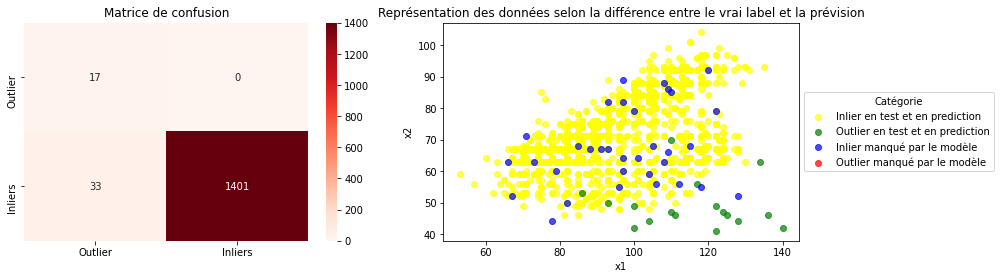

---------Deep MLP-----------
   accuracy   recall  True negative rate  False discovery rate
0  0.987595  0.67403            0.004881               0.00765


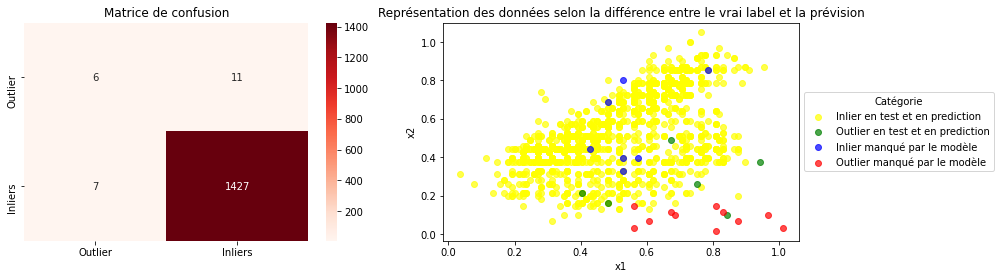

---------Local Outlier Factor-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.960717  0.544179            0.029289              0.010661


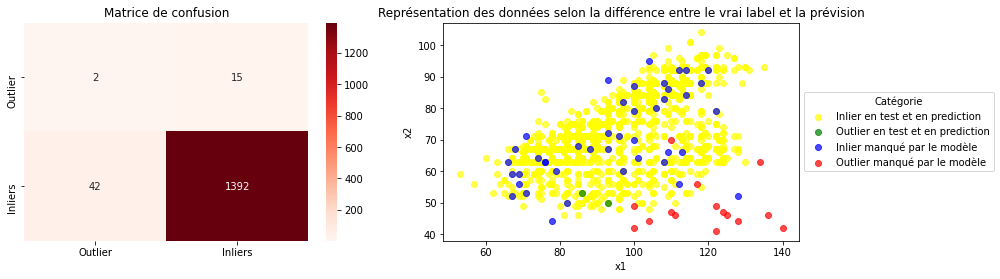

In [0]:
for name, algorithm in anomaly_algorithms_satimage:
  AlgoTrainPredict(name, algorithm, algo_particuliers, X_train, X_test, y_test, config, scale="MinMax",var1=10,var2=20)

### 2.3 Cas de speech

In [0]:
X_train, X_test, y_train, y_test, X_train_scaled, X_test_scaled = prepro_data(path + 'speech.mat', 'anomalies')

In [0]:
input_dim = X_train.shape[1]
autoencoder=CustomAutoencoder(input_dim)
nb_epoch = config["nb_epoch"]
batch_size = config["batch_size"]
autoencoder.compile(optimizer='adam', loss='mse' )

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 400)               0         
_________________________________________________________________
dense_37 (Dense)             (None, 10)                4010      
_________________________________________________________________
dense_38 (Dense)             (None, 5)                 55        
_________________________________________________________________
dense_39 (Dense)             (None, 2)                 12        
_________________________________________________________________
dense_40 (Dense)             (None, 5)                 15        
_________________________________________________________________
dense_41 (Dense)             (None, 10)                60        
_________________________________________________________________
dense_42 (Dense)             (None, 400)               4400

In [0]:
anomaly_algorithms_speech = [
    ('ABOD', ABOD(contamination=outlier_prop, n_neighbors=30)),
    ('HBOS', HBOS(contamination=outlier_prop)),
    ("One-Class SVM", OneClassSVM(nu=outlier_prop, kernel="rbf", gamma=0.0001)),
    ("Isolation Forest", IsolationForest(n_estimators=300, max_samples = 600, contamination=outlier_prop, max_features=180, random_state=42)),
    ("KNN", KNN(contamination = outlier_prop, n_neighbors=30)),
    ("Deep MLP", autoencoder),
    ("Local Outlier Factor", LocalOutlierFactor(n_neighbors=15, contamination=outlier_prop))
    ]
algo_particuliers = ["ABOD","HBOS","KNN","Local Outlier Factor","Deep MLP"]

---------ABOD-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.953362  0.563997              0.0299              0.017937


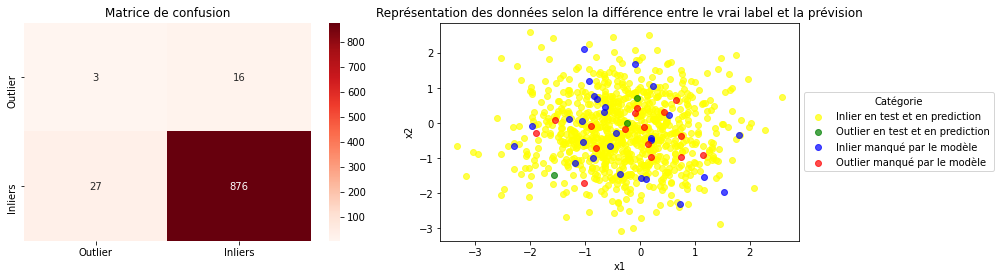

---------HBOS-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.950108  0.510812            0.031008              0.020157


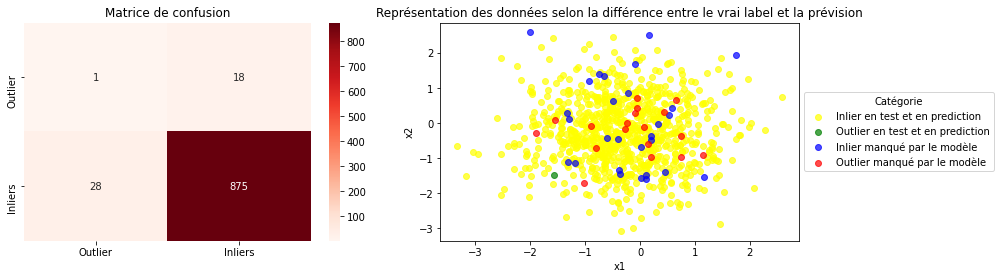

---------One-Class SVM-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.951193  0.537128            0.031008              0.019058


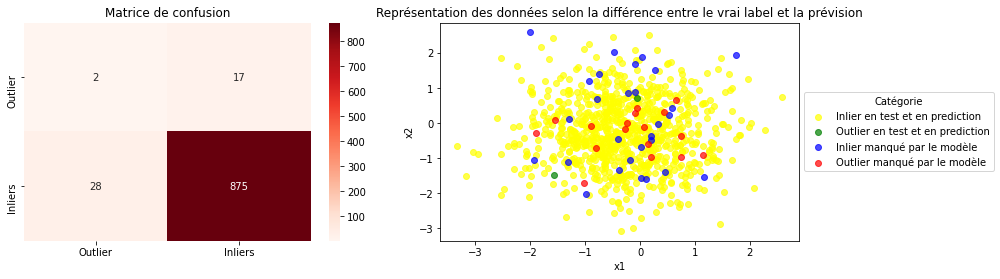

---------Isolation Forest-----------
   accuracy   recall  True negative rate  False discovery rate
0  0.955531  0.51358            0.025471              0.020045


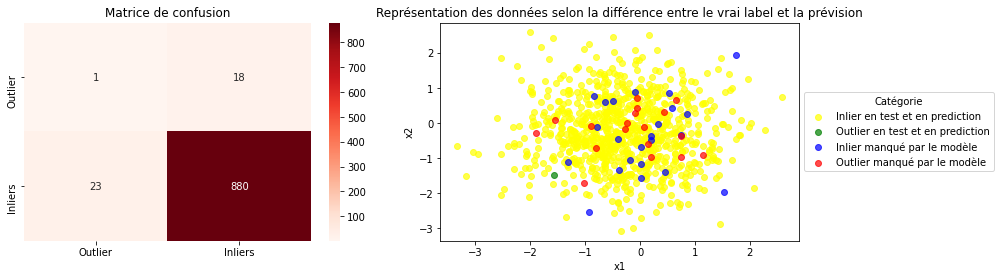

---------KNN-----------
   accuracy   recall  True negative rate  False discovery rate
0  0.955531  0.51358            0.025471              0.020045


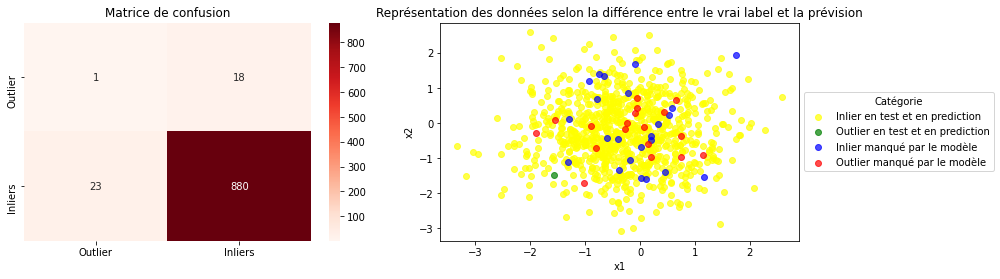

---------Deep MLP-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.975054  0.497785             0.00443              0.020697


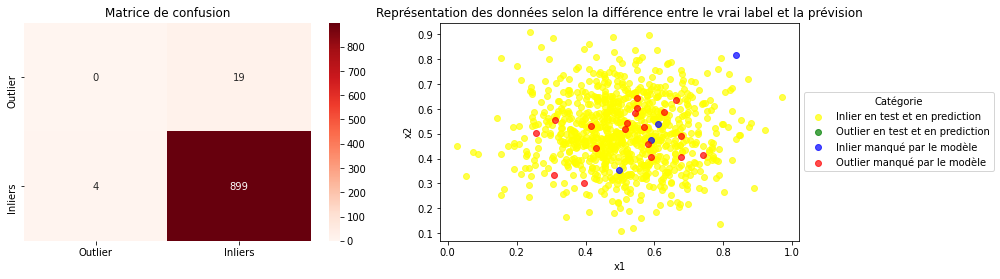

---------Local Outlier Factor-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.953362  0.538235            0.028793              0.019016


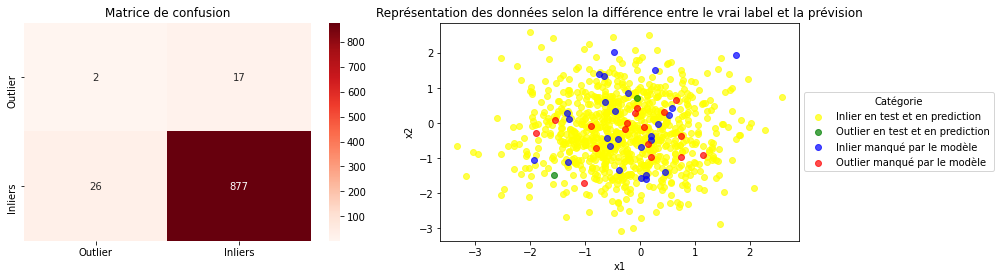

In [0]:
for name, algorithm in anomaly_algorithms_speech:
  AlgoTrainPredict(name, algorithm, algo_particuliers, X_train, X_test, y_test, config, scale="MinMax",var1=10,var2=20)

# 3. Détection de nouveautés

### 3.1 Cas de Simulation

In [0]:
input_dim = nb_var
autoencoder=CustomAutoencoder(input_dim)
nb_epoch = config["nb_epoch"]
batch_size = config["batch_size"]
autoencoder.compile(optimizer='adam', loss='mse' )

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
dense_43 (Dense)             (None, 10)                10010     
_________________________________________________________________
dense_44 (Dense)             (None, 5)                 55        
_________________________________________________________________
dense_45 (Dense)             (None, 2)                 12        
_________________________________________________________________
dense_46 (Dense)             (None, 5)                 15        
_________________________________________________________________
dense_47 (Dense)             (None, 10)                60        
_________________________________________________________________
dense_48 (Dense)             (None, 1000)              1100

In [0]:
novelty_algorithms_simul = [
    ("Robust covariance", EllipticEnvelope(contamination=outlier_prop)),
    ("One-Class SVM", OneClassSVM(nu=outlier_prop, kernel="rbf", gamma=0.0001)),
    ("Isolation Forest", IsolationForest(n_estimators=300, max_samples = 600, contamination=outlier_prop, max_features=30, random_state=42)),
    ("KNN", KNN(contamination = outlier_prop, n_neighbors=30)),
    ("Deep MLP", autoencoder),
    ("Local Outlier Factor", LocalOutlierFactor(n_neighbors=15, contamination=outlier_prop))
    ]
algo_particuliers = ["KNN","Local Outlier Factor","Deep MLP","Robust covariance"]

Cas des simulations gausiennes

%%%%%%%%%%%%%%%%%% index =  0


/usr/local/lib/python3.6/dist-packages/sklearn/covariance/_robust_covariance.py:644: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "


---------Robust covariance-----------
   accuracy  recall  True negative rate  False discovery rate
0       1.0     1.0                 0.0                   0.0


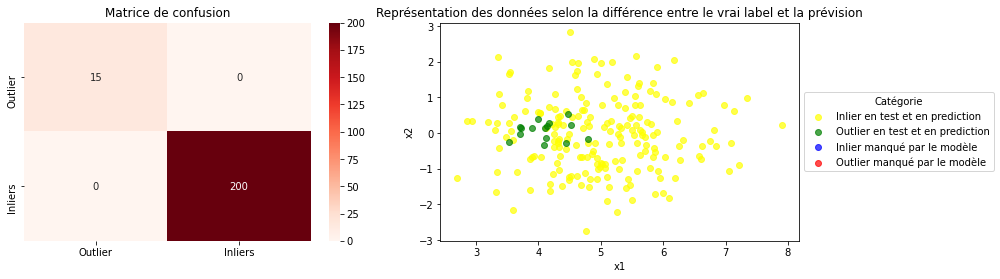

---------One-Class SVM-----------
   accuracy  recall  True negative rate  False discovery rate
0  0.832558  0.4475               0.105               0.07732


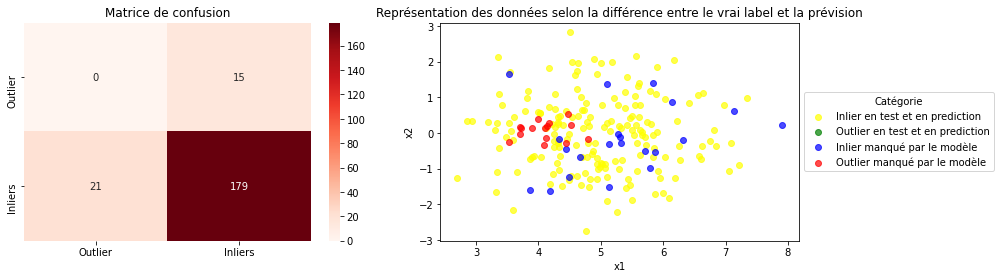

---------Isolation Forest-----------
   accuracy  recall  True negative rate  False discovery rate
0  0.860465  0.4625               0.075                 0.075


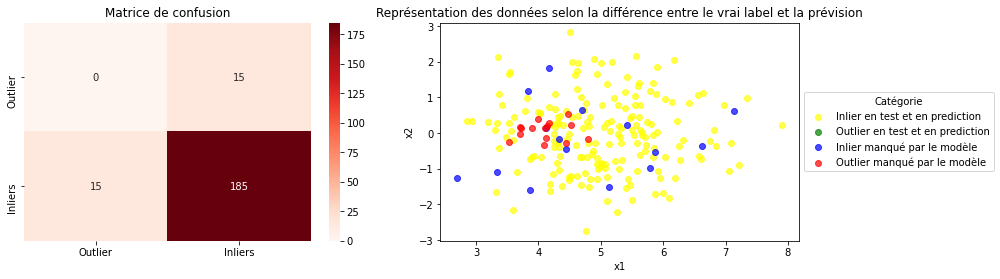

---------KNN-----------
   accuracy  recall  True negative rate  False discovery rate
0  0.897674  0.4825               0.035              0.072115


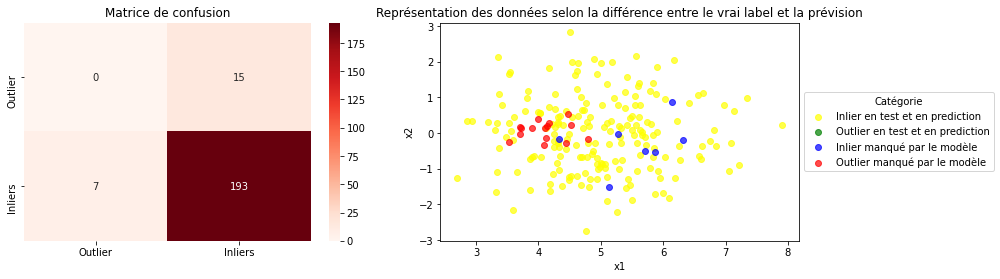

---------Deep MLP-----------
   accuracy  recall  True negative rate  False discovery rate
0  0.930233     0.5                 0.0              0.069767


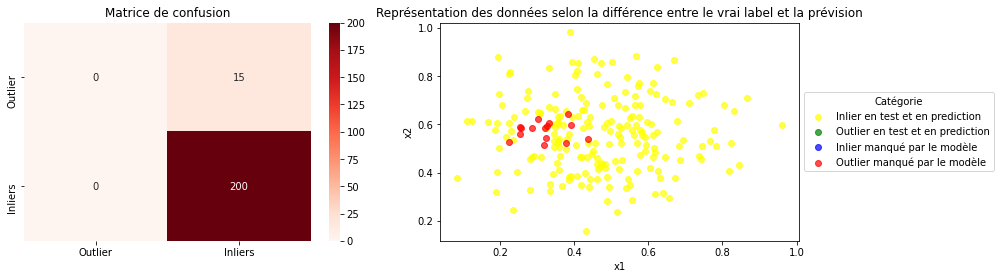

---------Local Outlier Factor-----------
   accuracy  recall  True negative rate  False discovery rate
0  0.897674  0.4825               0.035              0.072115


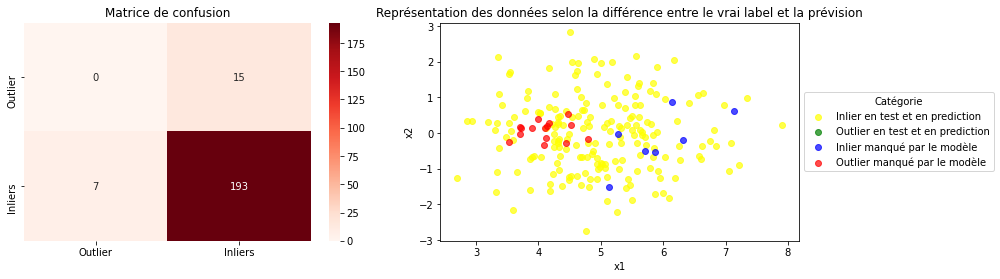

%%%%%%%%%%%%%%%%%% index =  1


/usr/local/lib/python3.6/dist-packages/sklearn/covariance/_robust_covariance.py:644: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "


---------Robust covariance-----------
   accuracy  recall  True negative rate  False discovery rate
0       1.0     1.0                 0.0                   0.0


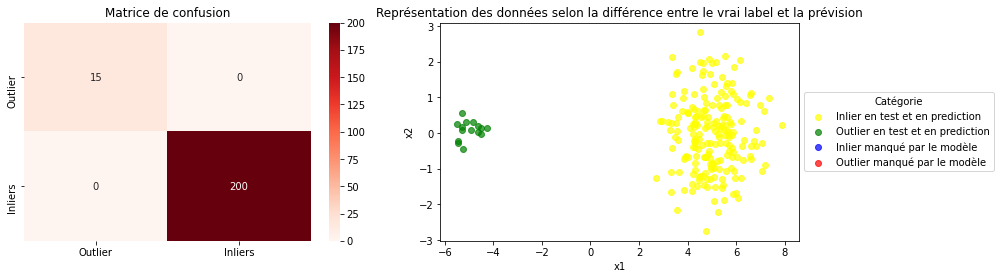

---------One-Class SVM-----------
   accuracy  recall  True negative rate  False discovery rate
0  0.832558  0.4475               0.105               0.07732


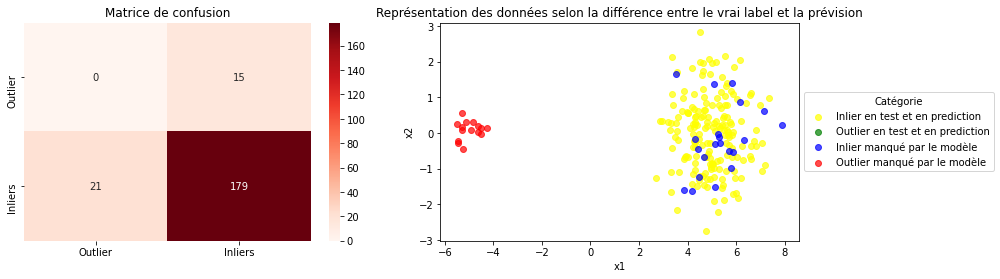

---------Isolation Forest-----------
   accuracy  recall  True negative rate  False discovery rate
0  0.860465  0.4625               0.075                 0.075


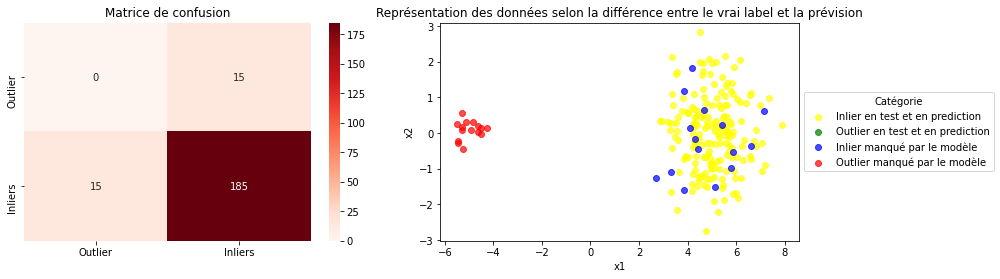

---------KNN-----------
   accuracy  recall  True negative rate  False discovery rate
0  0.897674  0.4825               0.035              0.072115


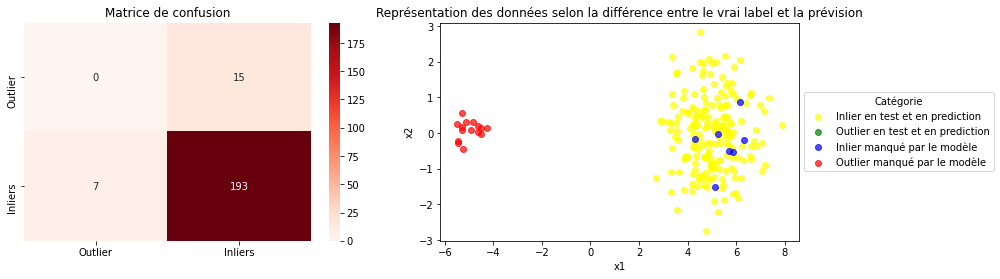

---------Deep MLP-----------
   accuracy  recall  True negative rate  False discovery rate
0  0.930233     0.5                 0.0              0.069767


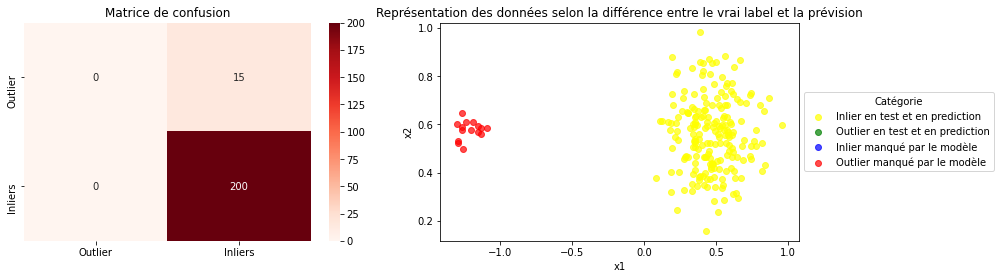

---------Local Outlier Factor-----------
   accuracy  recall  True negative rate  False discovery rate
0  0.897674  0.4825               0.035              0.072115


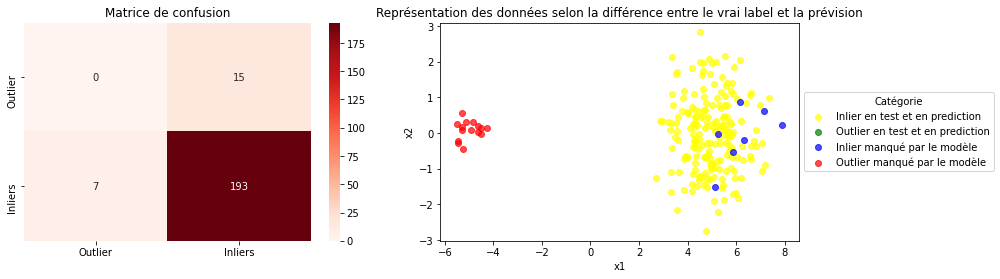

%%%%%%%%%%%%%%%%%% index =  2


/usr/local/lib/python3.6/dist-packages/sklearn/covariance/_robust_covariance.py:644: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "


---------Robust covariance-----------
   accuracy  recall  True negative rate  False discovery rate
0       1.0     1.0                 0.0                   0.0


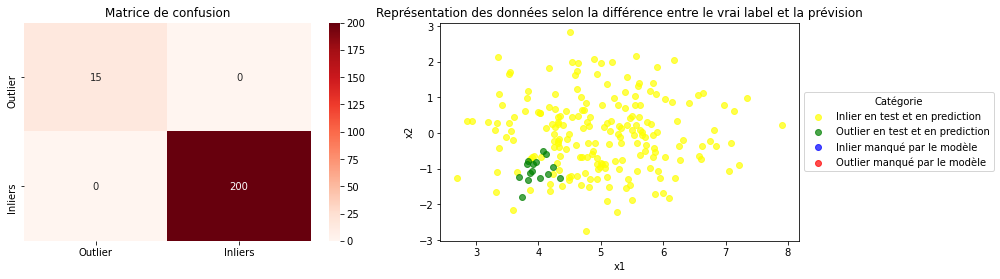

---------One-Class SVM-----------
   accuracy  recall  True negative rate  False discovery rate
0  0.832558  0.4475               0.105               0.07732


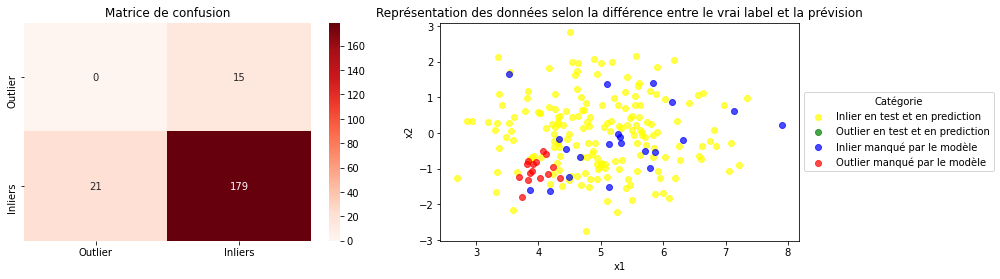

---------Isolation Forest-----------
   accuracy  recall  True negative rate  False discovery rate
0  0.860465  0.4625               0.075                 0.075


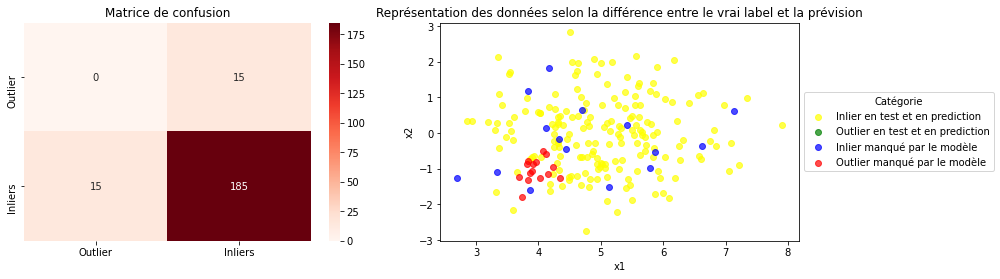

---------KNN-----------
   accuracy  recall  True negative rate  False discovery rate
0  0.897674  0.4825               0.035              0.072115


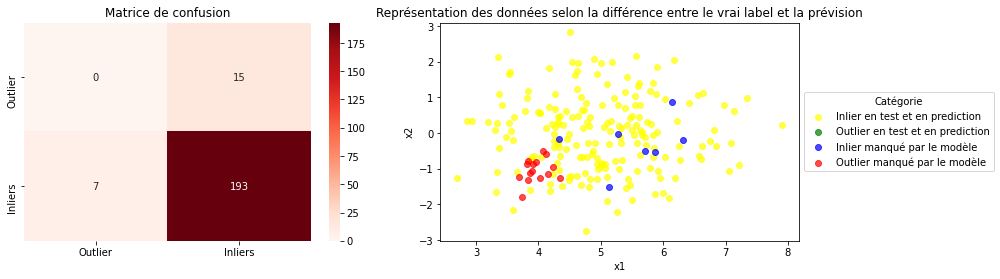

---------Deep MLP-----------
   accuracy  recall  True negative rate  False discovery rate
0  0.930233     0.5                 0.0              0.069767


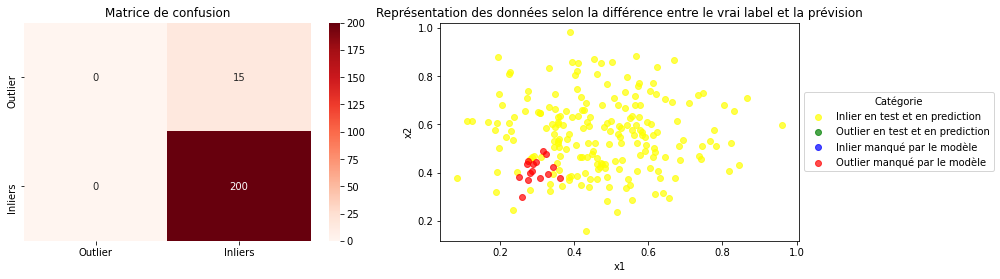

---------Local Outlier Factor-----------
   accuracy  recall  True negative rate  False discovery rate
0  0.897674  0.4825               0.035              0.072115


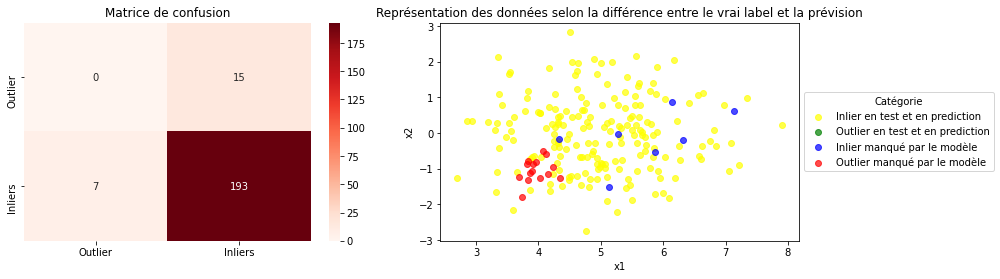

In [0]:
for index in range(len(gaussian_anomaly_list)):
    print("%%%%%%%%%%%%%%%%%% index = ",index)
    X_train, X_test, y_train, y_test, X_train_scaled, X_test_scaled = prepro_data(path + 'simulation_gaussienne_'+str(index)+'.mat', 'nouveautes')
    for name, algorithm in novelty_algorithms_simul:
        AlgoTrainPredict(name, algorithm, algo_particuliers, X_train, X_test, y_test, config, scale="MinMax",var1=0,var2=1)

Cas des simulations uniformes

/usr/local/lib/python3.6/dist-packages/sklearn/covariance/_robust_covariance.py:644: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "


---------Robust covariance-----------
   accuracy  recall  True negative rate  False discovery rate
0  0.930233     0.5                 0.0              0.069767


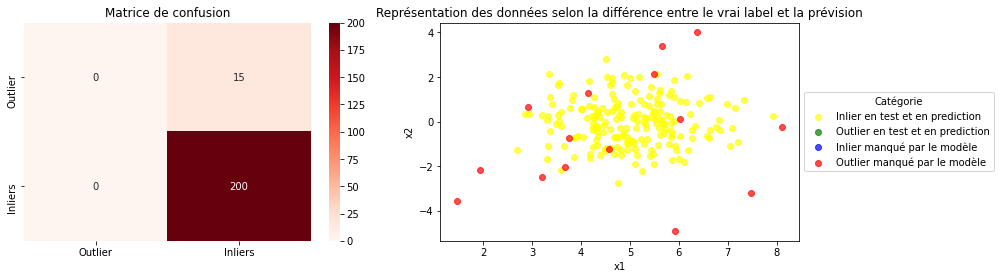

---------One-Class SVM-----------
   accuracy  recall  True negative rate  False discovery rate
0  0.902326  0.9475               0.105                   0.0


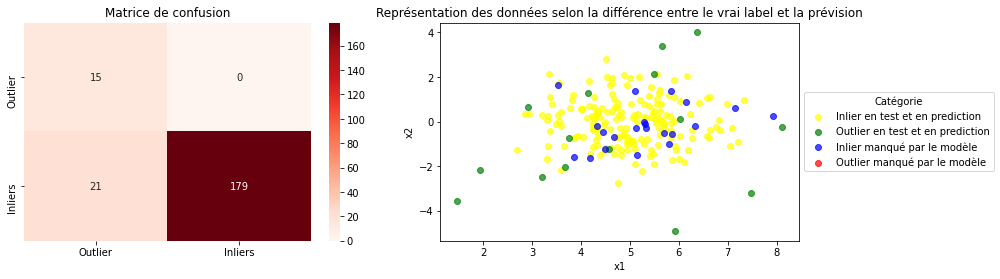

---------Isolation Forest-----------
   accuracy  recall  True negative rate  False discovery rate
0  0.930233  0.9625               0.075                   0.0


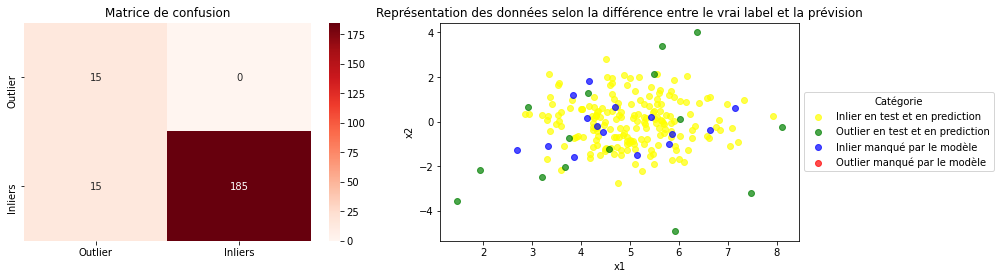

---------KNN-----------
   accuracy  recall  True negative rate  False discovery rate
0  0.967442  0.9825               0.035                   0.0


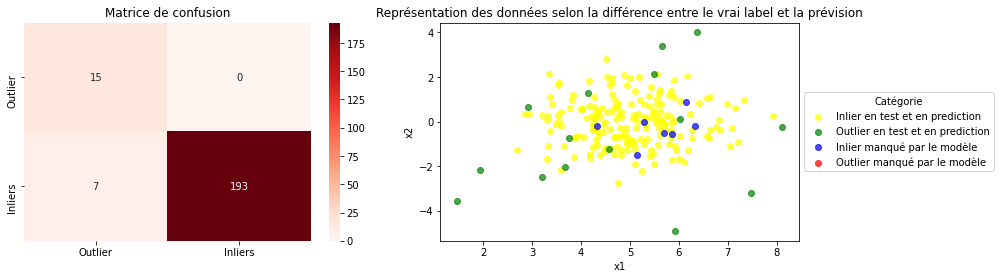

---------Deep MLP-----------
   accuracy  recall  True negative rate  False discovery rate
0       1.0     1.0                 0.0                   0.0


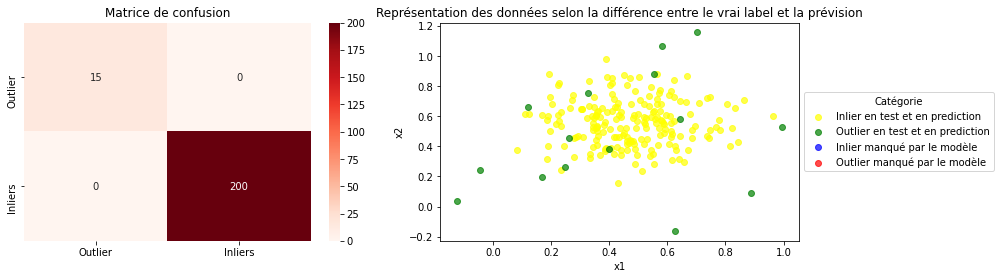

---------Local Outlier Factor-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.962791  0.733333                 0.0              0.038462


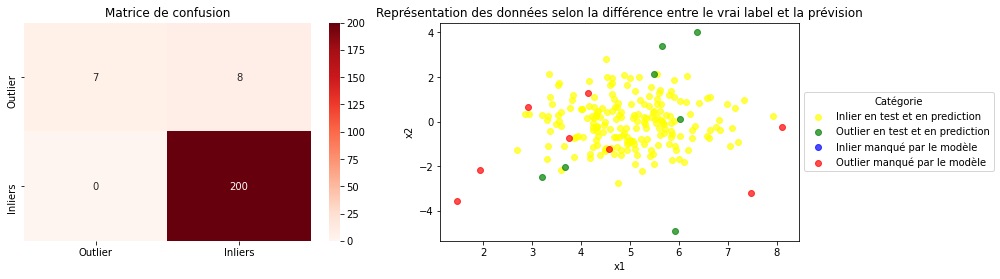

In [0]:
X_train, X_test, y_train, y_test, X_train_scaled, X_test_scaled = prepro_data(path + 'simulation_uniforme.mat', 'nouveautes')
for name, algorithm in novelty_algorithms_simul:
    AlgoTrainPredict(name, algorithm, algo_particuliers, X_train, X_test, y_test, config, scale="MinMax",var1=0,var2=1)

### 3.2 Cas de satimage

In [0]:
X_train, X_test, y_train, y_test, X_train_scaled, X_test_scaled = prepro_data(path + 'satimage-2.mat', 'nouveautes')

In [0]:
input_dim = X_train.shape[1]
autoencoder=CustomAutoencoder(input_dim)
nb_epoch = config["nb_epoch"]
batch_size = config["batch_size"]
autoencoder.compile(optimizer='adam', loss='mse' )

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 36)                0         
_________________________________________________________________
dense_49 (Dense)             (None, 10)                370       
_________________________________________________________________
dense_50 (Dense)             (None, 5)                 55        
_________________________________________________________________
dense_51 (Dense)             (None, 2)                 12        
_________________________________________________________________
dense_52 (Dense)             (None, 5)                 15        
_________________________________________________________________
dense_53 (Dense)             (None, 10)                60        
_________________________________________________________________
dense_54 (Dense)             (None, 36)                396 

In [0]:
novelty_algorithms_satimage = [
    ('ABOD', ABOD(contamination=outlier_prop, n_neighbors=30)),
    ('HBOS', HBOS(contamination=outlier_prop)),
    ("One-Class SVM", OneClassSVM(nu=outlier_prop, kernel="rbf", gamma=0.0001)),
    ("Isolation Forest", IsolationForest(n_estimators=300, max_samples = 600, contamination=outlier_prop, max_features=15, random_state=42)),
    ("KNN", KNN(contamination = outlier_prop, n_neighbors=30)),
    ("Deep MLP", autoencoder),
    ("Local Outlier Factor", LocalOutlierFactor(n_neighbors=15, contamination=outlier_prop))
    ]
algo_particuliers = ["ABOD","HBOS","KNN","Local Outlier Factor","Deep MLP"]

---------ABOD-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.970443  0.977701            0.030514              0.000898


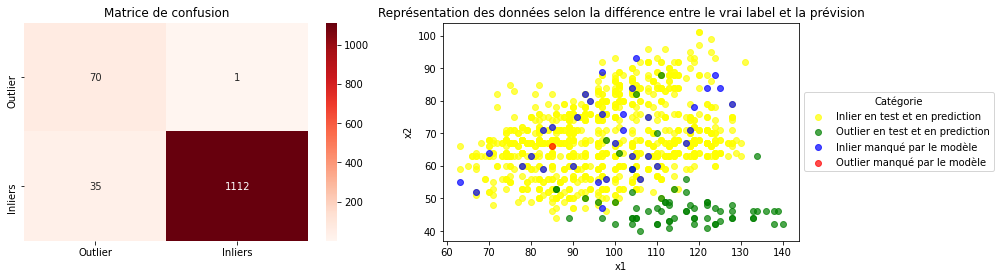

---------HBOS-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.982759  0.918176            0.008718              0.009582


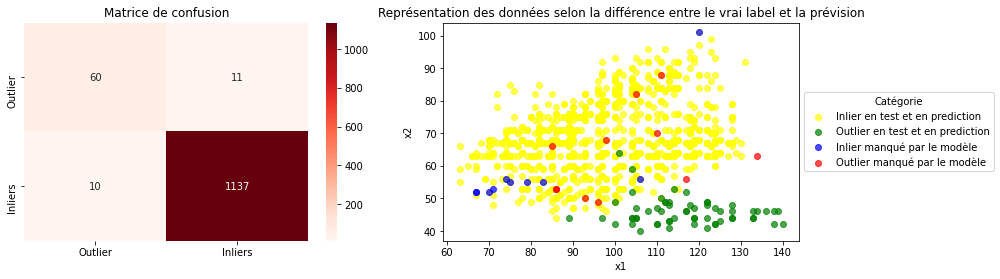

---------One-Class SVM-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.972085  0.971966            0.027899              0.001791


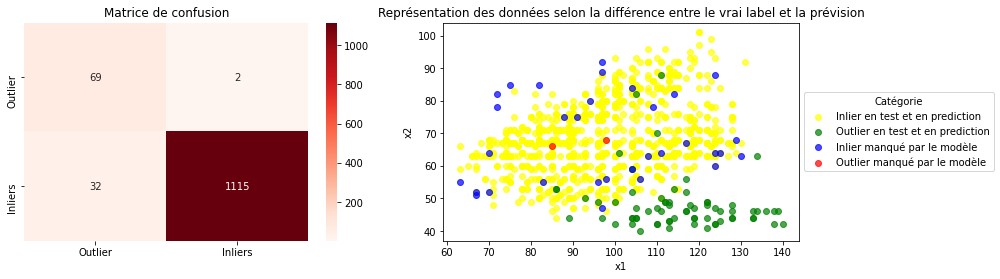

---------Isolation Forest-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.978654  0.975453            0.020924              0.001778


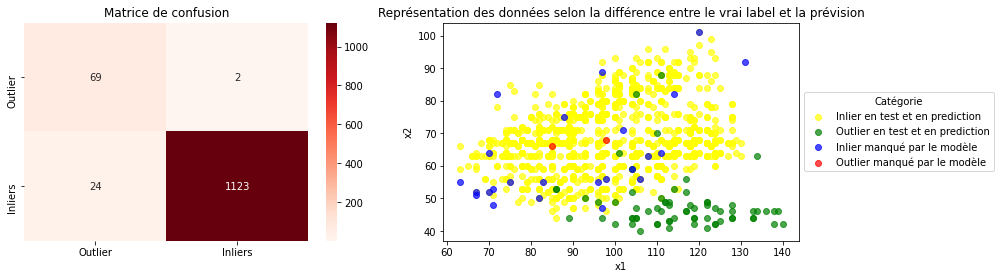

---------KNN-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.972085  0.985179            0.029643                   0.0


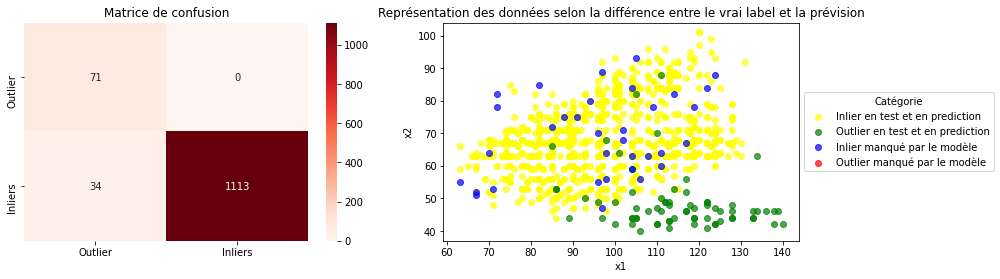

---------Deep MLP-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.990969  0.981992            0.007847              0.001754


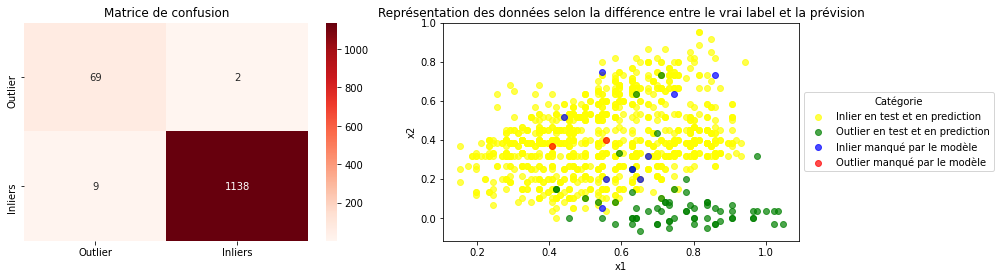

---------Local Outlier Factor-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.924466  0.543696            0.025283              0.053345


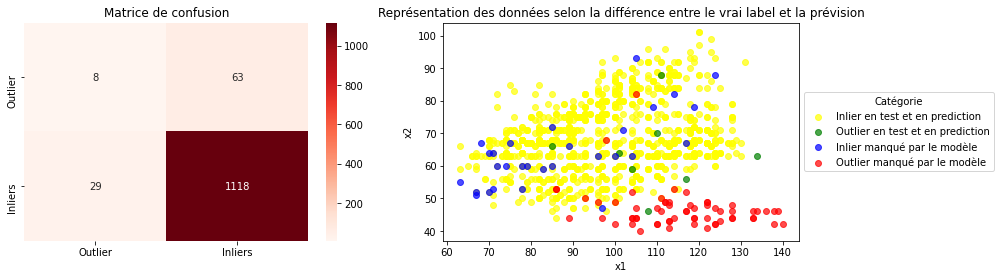

In [0]:
for name, algorithm in novelty_algorithms_satimage:
  AlgoTrainPredict(name, algorithm, algo_particuliers, X_train, X_test, y_test, config, scale="MinMax",var1=10,var2=20)

### 3.3 Cas de speech

In [0]:
X_train, X_test, y_train, y_test, X_train_scaled, X_test_scaled = prepro_data(path + 'speech.mat', 'nouveautes')

In [0]:
input_dim = X_train.shape[1]
autoencoder=CustomAutoencoder(input_dim)
nb_epoch = config["nb_epoch"]
batch_size = config["batch_size"]
autoencoder.compile(optimizer='adam', loss='mse' )

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 400)               0         
_________________________________________________________________
dense_55 (Dense)             (None, 10)                4010      
_________________________________________________________________
dense_56 (Dense)             (None, 5)                 55        
_________________________________________________________________
dense_57 (Dense)             (None, 2)                 12        
_________________________________________________________________
dense_58 (Dense)             (None, 5)                 15        
_________________________________________________________________
dense_59 (Dense)             (None, 10)                60        
_________________________________________________________________
dense_60 (Dense)             (None, 400)               440

In [0]:
novelty_algorithms_speech = [
    ('ABOD', ABOD(contamination=outlier_prop, n_neighbors=30)),
    ('HBOS', HBOS(contamination=outlier_prop)),
    ("One-Class SVM", OneClassSVM(nu=outlier_prop, kernel="rbf", gamma=0.0001)),
    ("Isolation Forest", IsolationForest(n_estimators=300, max_samples = 600, contamination=outlier_prop, max_features=180, random_state=42)),
    ("KNN", KNN(contamination = outlier_prop, n_neighbors=30)),
    ("Deep MLP", autoencoder),
    ("Local Outlier Factor", LocalOutlierFactor(n_neighbors=15, contamination=outlier_prop))
    ]
algo_particuliers = ["ABOD","HBOS","KNN","Local Outlier Factor","Deep MLP"]

---------ABOD-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.890585  0.550322            0.046897              0.069987


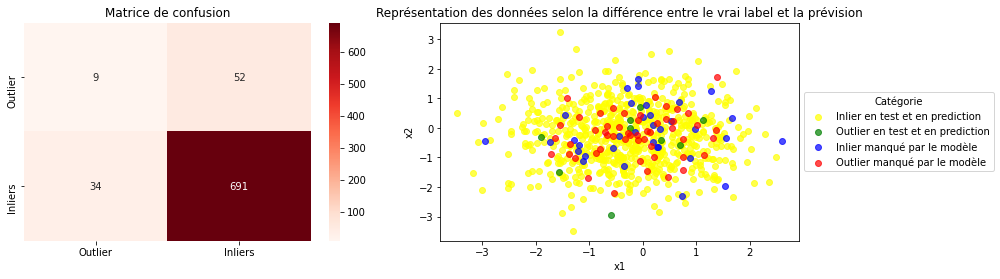

---------HBOS-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.784987  0.463053            0.155862              0.083832


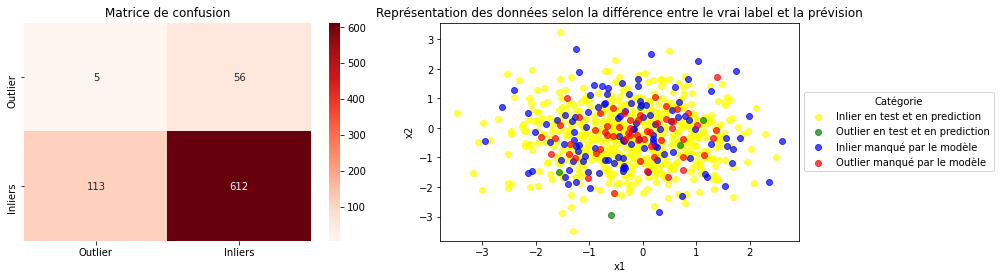

---------One-Class SVM-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.776081  0.465732            0.166897               0.08346


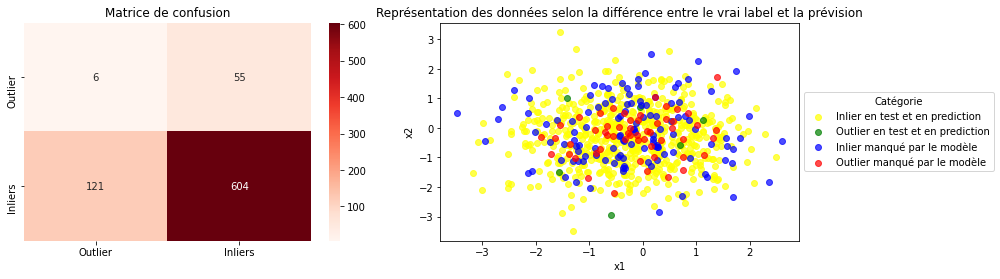

---------Isolation Forest-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.795165  0.476077            0.146207              0.081602


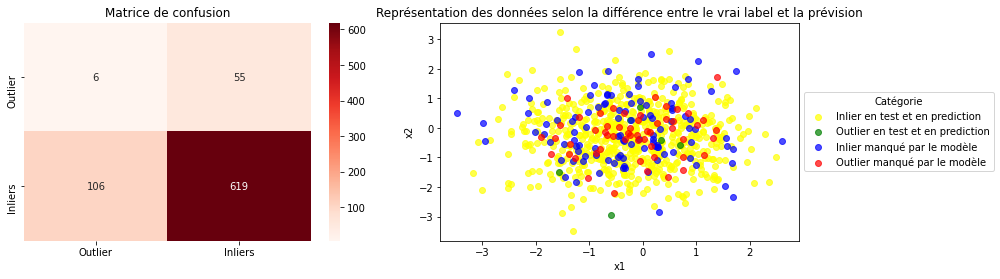

---------KNN-----------
   accuracy    recall  True negative rate  False discovery rate
0   0.78626  0.471249            0.155862              0.082459


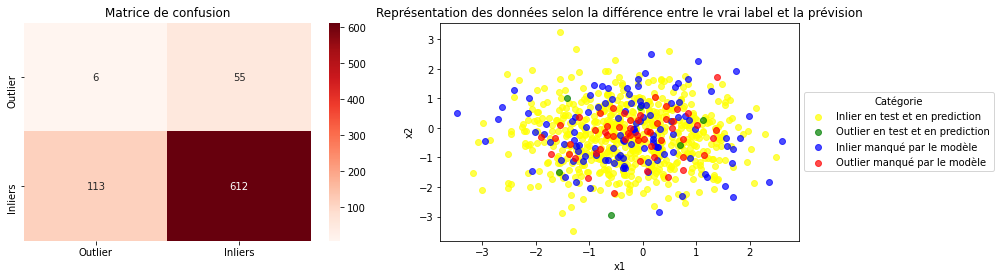

---------Deep MLP-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.881679  0.485438            0.045517              0.079787


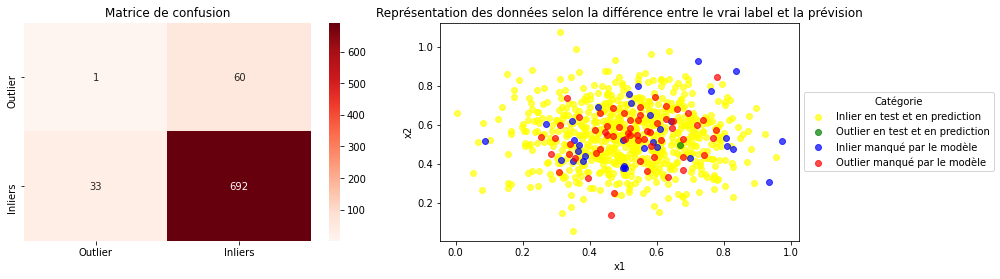

---------Local Outlier Factor-----------
   accuracy    recall  True negative rate  False discovery rate
0  0.894402  0.492335            0.031724               0.07874


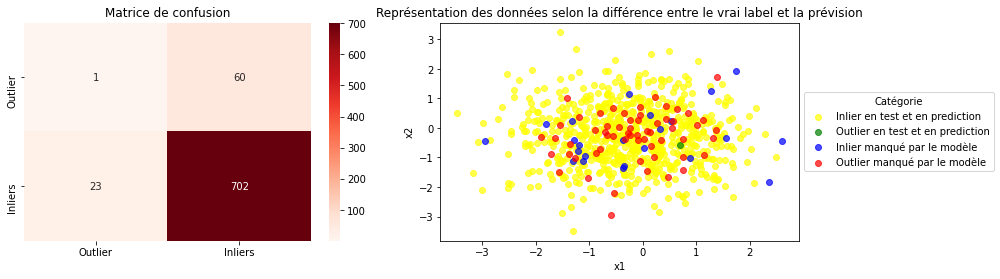

In [0]:
for name, algorithm in novelty_algorithms_speech:
  AlgoTrainPredict(name, algorithm, algo_particuliers, X_train, X_test, y_test, config, scale="MinMax",var1=10,var2=20)

# 4. Impact du taux de contamination

In [0]:
# Base satimage 
# path ="data/"
X, y = upload_data(path + 'satimage-2.mat')
X_train, X_test, y_train, y_test, X_train_scaled, X_test_scaled = prepro_data(path + 'satimage-2.mat', 'anomalies')

In [73]:
true_contamination = np.round(np.sum(y==-1)/len(y),4)
config["contamination_list"] = [true_contamination/50, true_contamination/10,true_contamination/5, true_contamination/2, true_contamination,
                                true_contamination*2, true_contamination*5,true_contamination*10,true_contamination*50]
print(config["contamination_list"])
config["contamination_name"] = ["/50","/10","/5","/2","true","x2","x5","x10","x50"]

[0.00024400000000000002, 0.0012200000000000002, 0.0024400000000000003, 0.0061, 0.0122, 0.0244, 0.061000000000000006, 0.12200000000000001, 0.61]


In [0]:
input_dim = X_train.shape[1]
autoencoder=CustomAutoencoder(input_dim)
nb_epoch = config["nb_epoch"]
batch_size = config["batch_size"]
autoencoder.compile(optimizer='adam', loss='mse' )

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 36)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 10)                370       
_________________________________________________________________
dense_14 (Dense)             (None, 5)                 55        
_________________________________________________________________
dense_15 (Dense)             (None, 2)                 12        
_________________________________________________________________
dense_16 (Dense)             (None, 5)                 15        
_________________________________________________________________
dense_17 (Dense)             (None, 10)                60        
_________________________________________________________________
dense_18 (Dense)             (None, 36)                396 

In [0]:
anomaly_algorithms_satimage = [
    ('ABOD', ABOD(contamination=outlier_prop, n_neighbors=30)),
    ('HBOS', HBOS(contamination=outlier_prop)),
    ("One-Class SVM", OneClassSVM(nu=outlier_prop, kernel="rbf", gamma=0.0001)),
    ("Isolation Forest", IsolationForest(n_estimators=300, max_samples = 600, contamination=outlier_prop, max_features=30, random_state=42)),
    ("KNN", KNN(contamination = outlier_prop, n_neighbors=30)),
    ("Deep MLP", autoencoder),
    ("Local Outlier Factor", LocalOutlierFactor(n_neighbors=15, contamination=outlier_prop))
    ]
algo_particuliers = ["ABOD","HBOS","KNN","Local Outlier Factor","Deep MLP"]

In [0]:
dict_result={}

for i, (clf_name, clf) in enumerate(anomaly_algorithms_satimage):
    print("\n---------------------"+clf_name+"---------------------")
    print("Classifier with correct contamination : ", clf)
    dict_result[clf_name]={}
    
    for contamination in config["contamination_list"]:
        print('\n----Contamination rate : '+str(contamination)+'----')
        
        # update contamination of the classifier
        clf.contamination=contamination
        contamination_name = str(contamination)
        
        dict_result[clf_name][contamination_name]={}
        
        # Fit on training data
        _, eval_ = AlgoTrainPredict(clf_name, clf, algo_particuliers, X_train, X_test, y_test, config, scale="MinMax",var1=10,var2=20)
        dict_result[clf_name][contamination_name]=eval_
        print(eval_)

In [0]:
import pickle as pkl
# pkl.dump(dict_result,open("dict_result_satimage_contamination.pkl","wb"))
res = pkl.load(open("dict_result_satimage_contamination.pkl","rb"))

In [19]:
print(res.keys())
index = 0
print(config["contamination_list"][index])
res["ABOD"][str(config["contamination_list"][index])]

dict_keys(['ABOD', 'HBOS', 'One-Class SVM', 'Isolation Forest', 'KNN', 'Deep MLP', 'Local Outlier Factor'])
0.00024400000000000002


accuracy  recall  True negative rate  False discovery rate
0  0.988284     0.5                 0.0              0.011716

In [0]:
def plot_result(dict_result, metric, remove_contam_beg = 0, remove_contam_end = 0, logscale=True,font="small") :
    for clf_name in dict_result.keys() :
        metric_list = []
        if remove_contam_end == 0 :
            contam_list = list(dict_result[clf_name].keys())[remove_contam_beg:]
            contam_nb = config["contamination_list"][remove_contam_beg:]
        else :
            contam_list = list(dict_result[clf_name].keys())[remove_contam_beg:-remove_contam_end]
            contam_nb = config["contamination_list"][remove_contam_beg:-remove_contam_end]
        for contamination in contam_list:
            try :
                metric_list.append(dict_result[clf_name][contamination][metric].iloc[0])
            except :
                break
        if logscale == True :
          plt.scatter(np.log(contam_nb[:len(metric_list)]),metric_list[:len(contam_nb)],label = clf_name)
          plt.plot(np.log(contam_nb[:len(metric_list)]),metric_list[:len(contam_nb)])
          plt.xticks(np.log(contam_nb),labels=config["contamination_name"])
        else :
          plt.scatter(contam_nb[:len(metric_list)],metric_list[:len(contam_nb)],label = clf_name)
          plt.plot(contam_nb[:len(metric_list)],metric_list[:len(contam_nb)])
          plt.xticks(contam_nb,labels=config["contamination_name"])
    plt.title(str(metric)+" en fonction du taux de contamination")
    if logscale == True :
      plt.axvline(np.log(true_contamination), label="Vrai taux d'anomalies",color = "y")
      plt.xlabel("Taux de contamination (échelle log)")
    else :
      plt.axvline(true_contamination, label="Vrai taux d'anomalies",color = "y")
      plt.xlabel("Taux de contamination")
    plt.ylabel(metric)
    if font=="small":
      plt.legend(prop=fontP)
    else :
      plt.legend()
    plt.show()

In [0]:
from matplotlib.font_manager import FontProperties

fontP = FontProperties()
fontP.set_size('small')

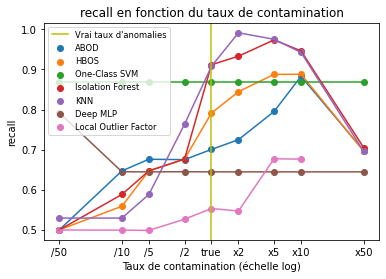

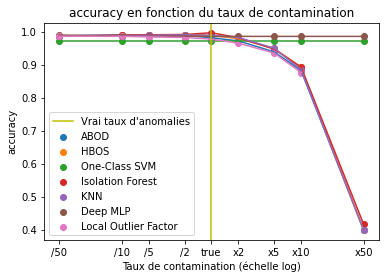

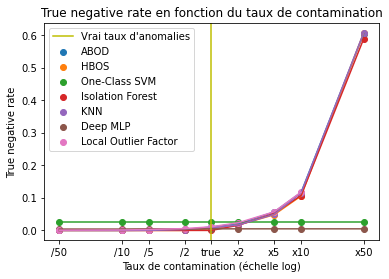

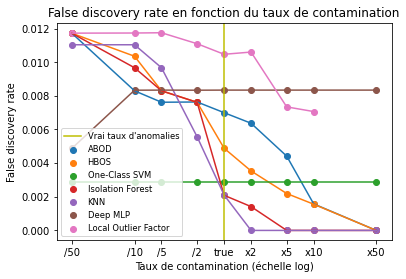

In [94]:
plot_result(res,"recall", remove_contam_beg = 0, remove_contam_end = 0, logscale=True, font="small")
plot_result(res,"accuracy", remove_contam_beg = 0, remove_contam_end = 0, logscale=True, font="large")
plot_result(res,"True negative rate", remove_contam_beg = 0, remove_contam_end = 0, logscale=True, font="large")
plot_result(res,"False discovery rate", remove_contam_beg = 0, remove_contam_end = 0, logscale=True, font="small")

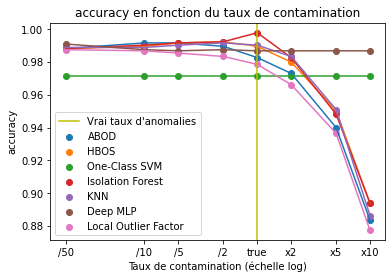

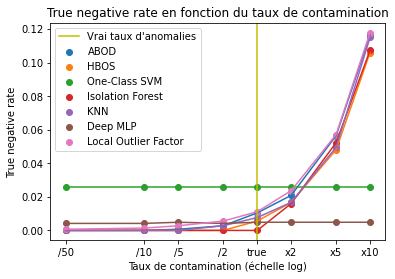

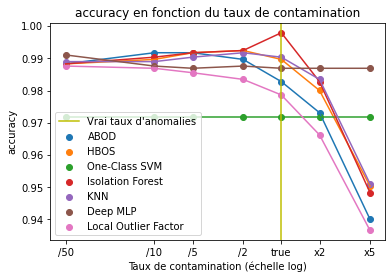

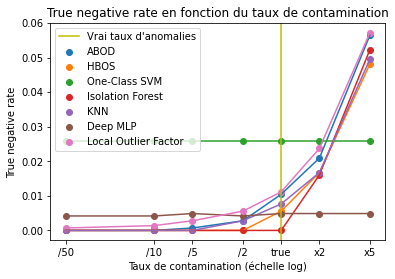

In [95]:
plot_result(res,"accuracy", remove_contam_beg = 0, remove_contam_end = 1, logscale=True, font="large")
plot_result(res,"True negative rate", remove_contam_beg = 0, remove_contam_end = 1, logscale=True, font="large")

plot_result(res,"accuracy", remove_contam_beg = 0, remove_contam_end = 2, logscale=True, font="large")
plot_result(res,"True negative rate", remove_contam_beg = 0, remove_contam_end = 2, logscale=True, font="large")
